<a href="https://colab.research.google.com/github/taoye9/Experiments-MIA/blob/master/MIA_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
bz = 32 # batch size
ration_attack_train = 0.7 # for attack mode training and testing 

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# experiment 1: directly membership detection on target model

In [0]:
from torch.utils.data.dataset import ConcatDataset, random_split

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# prepare data

# Testset is used for eval of all model
testloader =  torch.utils.data.DataLoader(testset, batch_size=bz,
                                         shuffle=False, num_workers=2)


num_target_train = 15000
num_shadow_train = len(trainset)-num_target_train
print('target train dataset size is:{}\tshadow training set size is: {}'.format(num_target_train, num_shadow_train))

Dataset_target_train, Dataset_shadow_train = random_split(trainset, [num_target_train, num_shadow_train])

loader_target_train = torch.utils.data.DataLoader(Dataset_target_train, batch_size=bz,
                                          shuffle=True, num_workers=2)

0it [00:00, ?it/s]

170500096it [00:02, 71022992.66it/s]                               


Files already downloaded and verified
target train dataset size is:15000	shadow training set size is: 35000


## define target model 
from pytorch tutorial: https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py

In [0]:
import torch.nn as nn
import torch.nn.functional as F


#LeNet 
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [0]:
import torch.optim as optim

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('dev: {} \n'.format(dev))
    
net = Net()
net = net.to(dev)
if dev == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70], gamma=0.5)

dev: cuda 



In [0]:
def train(epoch, trainData=loader_target_train, log_interval=200):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    scheduler.step(epoch)
    for batch_idx, (inputs, targets) in enumerate(loader_target_train):
        data, targets = inputs.to(dev), targets.to(dev)
        optimizer.zero_grad()
        outputs = net(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % log_interval == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, accuracy: {:.6f}: {}/{}'.format(epoch, batch_idx * len(data), len(loader_target_train.dataset),100. * batch_idx / len(loader_target_train), train_loss/(batch_idx+1), 100.*correct/total, correct, total))

In [0]:
def test(epoch, testData=testloader):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(dev), targets.to(dev)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print(epoch, len(testloader), 'TESTING: Loss: %.3f | Acc: %.3f%% (%d/%d)'
        % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

In [7]:
start_epoch = 0

for epoch in range(start_epoch, start_epoch+75):
    train(epoch)
    test(epoch)


Epoch: 0
Train Epoch: 0 [0/15000 (0%)]	Loss: 2.296122, accuracy: 12.500000: 4/32
Train Epoch: 0 [6400/15000 (43%)]	Loss: 2.044741, accuracy: 23.849502: 1534/6432
Train Epoch: 0 [12800/15000 (85%)]	Loss: 1.892108, accuracy: 30.042082: 3855/12832
0 313 TESTING: Loss: 1.636 | Acc: 39.980% (3998/10000)

Epoch: 1
Train Epoch: 1 [0/15000 (0%)]	Loss: 1.410623, accuracy: 43.750000: 14/32
Train Epoch: 1 [6400/15000 (43%)]	Loss: 1.581895, accuracy: 41.806592: 2689/6432
Train Epoch: 1 [12800/15000 (85%)]	Loss: 1.560453, accuracy: 43.321384: 5559/12832
1 313 TESTING: Loss: 1.495 | Acc: 45.960% (4596/10000)

Epoch: 2
Train Epoch: 2 [0/15000 (0%)]	Loss: 1.346161, accuracy: 50.000000: 16/32
Train Epoch: 2 [6400/15000 (43%)]	Loss: 1.470775, accuracy: 47.481343: 3054/6432
Train Epoch: 2 [12800/15000 (85%)]	Loss: 1.451925, accuracy: 47.740025: 6126/12832
2 313 TESTING: Loss: 1.448 | Acc: 47.100% (4710/10000)

Epoch: 3
Train Epoch: 3 [0/15000 (0%)]	Loss: 1.304267, accuracy: 43.750000: 14/32
Train Epoch:

KeyboardInterrupt: ignored

In [0]:
class NNmodel:
  def __init__(self,net):
    self.net = net().to(dev)
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.net.parameters())
    self.scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[40, 70], gamma=0.5)
  
  def train(self, epoch, dataLoader, log_interval=200):
    print('\nEpoch: %d' % epoch)
    self.net.train()
    train_loss = 0
    correct = 0
    total = 0
    self.scheduler.step(epoch)
    for batch_idx, (inputs, targets) in enumerate(dataLoader):
        data, targets = inputs.to(dev), targets.to(dev)
        self.optimizer.zero_grad()
        outputs = self.net(data)
        loss = self.criterion(outputs, targets)
        loss.backward()
        self.optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % log_interval == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, accuracy: {:.6f}: {}/{}'.format(epoch, batch_idx * len(data), len(dataLoader.dataset),100. * batch_idx / len(dataLoader), train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return 
  
  def test(self,epoch, testLoader):
    self.net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testLoader):
            inputs, targets = inputs.to(dev), targets.to(dev)
            outputs = self.net(inputs)
            loss =self.criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print(epoch, len(testLoader), 'TESTING: Loss: %.3f | Acc: %.3f%% (%d/%d)'
        % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

# the following is a defender model

In [0]:
defender = NNmodel(Net)

start_epoch = 0

for epoch in range(start_epoch, start_epoch+75):
    defender.train(epoch, dataLoader=testloader)
    defender.test(epoch, testLoader=loader_target_train)

## explore confidence values between member and non-member

In [0]:
def TargetModelInference(target_model, dataset, defender_net=None, is_train=True):
    target_model.to(dev)
    target_model.eval()
    loader = torch.utils.data.DataLoader(dataset, batch_size=2)
    
    x = torch.tensor([]).to(dev)
    y = torch.tensor([])
    classes = torch.tensor([], dtype=torch.long)
    
    if defender_net is not None and is_train:
      global defender_x 
      global defender_y
      global defender_c
      defender_x = torch.tensor([]).to(dev)
      defender_y = torch.tensor([])
      defender_c = torch.tensor([], dtype=torch.long)
      defender_net.to(dev)
      defender_net.eval()
      
    with torch.no_grad(): # generate target model's posteriors
      for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(dev), targets.to('cpu')
#             print(targets.shape)
#             print(classes.shape)
            
            # get defender's posteriors for training dataset
            if defender_net is not None and is_train:
              defender_outputs = F.softmax(defender_net(inputs), dim=1)
              defender_x =  torch.cat([defender_x, defender_outputs], dim=0)
              defender_c = torch.cat([defender_c, targets], dim=0)
              defender_y = y = torch.ones(defender_x.shape[0])
              
#             outputs = torch.cat([outputs, targets.float()], dim=1)
            outputs = F.softmax(net(inputs), dim=1)
            classes = torch.cat([classes, targets], dim=0)
            x = torch.cat([x, outputs], dim=0)
    if is_train:
      y = torch.ones(x.shape[0])
    else:
      y = torch.zeros(x.shape[0])
      
    if defender_net is not None and is_train:
      defender_x = defender_x.to('cpu')
      defender_y = defender_y.int().to('cpu')
      defender_c = defender_c.to('cpu')
    return x.to('cpu'), y.int().to('cpu'), classes

In [0]:
x_in, y_in, c_in = TargetModelInference(net, Dataset_target_train, defender.net, is_train=True)
x_out, y_out, c_out = TargetModelInference(net, testset, is_train=False)


if len(testset) < len(Dataset_target_train):
  num_samples = len(testset)
  ind = torch.randperm(len(Dataset_target_train))[0:num_samples]
  x_in, y_in, c_in = x_in[ind], y_in[ind], c_in[ind]
  if defender_x is not None:
    defender_x, defender_y, defender_c = defender_x[ind], defender_y[ind], defender_c[ind]
else:
  num_samples = len(Dataset_target_train)
  ind = torch.randperm(len(testset))[0:num_samples]
  x_out, y_out, c_out = x_out[ind], y_out[ind], c_out[ind]
  
  
print('test acc for attack model input', torch.argmax(x_out, dim=1).eq(c_out).sum().item()/x_out.shape[0])
print('ttain acc for attack model input',torch.argmax(x_in, dim=1).eq(c_in).sum().item()/x_in.shape[0])

print(x_in.shape, y_in.shape, c_in.shape)


# explore defender posteriors

In [0]:
print(defender_x.shape)
print(defender_y.shape)
print(defender_c.shape)

print('acc for defender model input', torch.argmax(defender_x, dim=1).eq(defender_c).sum().item()/defender_x.shape[0])

values, indices = torch.max(defender_x, dim=1)
print(indices)
print(values)

In [0]:
number_class = 10

def swap_defender_posteriors(number_class, defender_x, target_x, defender_c):
  newXs = None
  _, class_ids = torch.max(target_x, dim=-1)
  print(class_ids.shape)
  print(defender_x.shape)
  for i in range(0, defender_x.shape[0]):
    x = defender_x[i, :]
    class_id = class_ids[i]
    values, ind_max = torch.max(x, dim=-1)
    
    indices = list(range(0, number_class))
    indices[class_id], indices[ind_max] = indices[ind_max], indices[class_id]
    indices = torch.LongTensor(indices)

    x = x[indices].unsqueeze(dim=0)

    if newXs is None: 
      newXs = x
    else:
      newXs = torch.cat([newXs, x], dim=0)
      
  print('acc of randomized defender model posteriors', torch.argmax(newXs, dim=1).eq(defender_c).sum().item()/newXs.shape[0])
  return newXs 

new_defender_x = swap_defender_posteriors(number_class, defender_x, x_in, defender_c)

In [0]:
def balance_samples(x_in, y_in, c_in, x_out, y_out, c_out):
  if len(testset) < len(Dataset_target_train):
    num_samples = len(testset)
    ind = torch.randperm(len(Dataset_target_train))[0:num_samples]
    x_in, y_in, c_in = x_in[ind], y_in[ind], c_in[ind]
  else:
    num_samples = len(Dataset_target_train)
    ind = torch.randperm(len(testset))[0:num_samples]
    x_out, y_out, c_out = x_out[ind], y_out[ind], c_out[ind]

  
  print('train acc:',torch.argmax(x_in, dim=1).eq(c_in).sum().item()/x_in.shape[0])
  print('test acc:', torch.argmax(x_out, dim=1).eq(c_out).sum().item()/x_out.shape[0])
  
  print('in data size')
  print(x_in.shape, y_in.shape, c_in.shape)
  print('out data size')
  print(x_out.shape, y_out.shape, c_out.shape)
  
  return x_in, y_in, c_in, x_out, y_out, c_out
  
  

In [0]:
import numpy as np
in_entropy = -(x_in*x_in.log()).sum(dim=-1)
out_entropy = -(x_out*x_out.log()).sum(dim=-1)
import matplotlib.pyplot as plt

print(in_entropy.shape)
print(out_entropy.shape)

x = in_entropy.numpy()
y = out_entropy.numpy()

print(x)
plt.hist([x, y], label=['member', 'non-member'])
plt.legend(loc='upper right')
plt.show()

In [0]:
import scipy.stats
x_np =  x_in.numpy()
in_entropy = []
print(x_in.numpy().shape)
for i in range(0, x_np.shape[0]):
  in_entropy.append(scipy.stats.entropy(x_np[i][:]))

x_np = x_out.numpy()
out_entropy = []
for i in range(0, x_np.shape[0]):
  out_entropy.append(scipy.stats.entropy(x_np[i][:]))
  
plt.hist([in_entropy, out_entropy], label=['in_entropy', 'out_entropy'])
plt.legend(loc='upper right')
plt.show()


In [0]:
in_sorted, indices = torch.sort(torch.tensor(in_entropy))
out_sorted, indices = torch.sort(torch.tensor(out_entropy))


for thres in np.arange(0, 1.4, 0.01):
  TP = (in_sorted < thres).sum().item()
  FP = (out_sorted < thres).sum().item()

  FN = (in_sorted >= thres).sum().item()
  TN = (out_sorted >= thres).sum().item()


  if TP != 0:
    p = TP / (TP + FP)
    r = TP / (TP + FN)
  else:
    p = 0
    r = 0

  print('thres:', thres, 'precision: ', p, 'recall', r)

In [0]:
from sklearn.decomposition import PCA
def plot_pca(x_in, x_out, samples=1000):
  pca = PCA(n_components=2)
  upper_bound_1 = x_in.shape[0]
  upper_bound_2 = x_out.shape[0]
  
  num_samples = min(x_in.shape[0], x_out.shape[0], samples)
  
  ind1 = torch.randperm(upper_bound_1)[0:num_samples]
  ind2 = torch.randperm(upper_bound_2)[0:num_samples]
  
  p_in = pca.fit_transform(x_in[ind1].numpy())
  p_out = pca.fit_transform(x_out[ind2].numpy())
  
  print(ind1.shape)
  
  plt.scatter(p_in[:,0], p_in[:,1], label='member')
  plt.scatter(p_out[:,0], p_out[:,1], label='non-member')

  plt.legend(loc='upper right')
  plt.show()
  
  x_in_sorted = torch.sort(x_in[ind1], dim=-1,  descending=True)
  x_out_sorted = torch.sort(x_out[ind2], dim=-1,  descending=True)

  p_in = pca.fit_transform(x_in[:, :3].numpy())
  p_out = pca.fit_transform(x_out[:, :3].numpy())
  print(ind1.shape)

  plt.scatter(p_in[:,0], p_in[:,1], label='member')
  plt.scatter(p_out[:,0], p_out[:,1], label='non-member')

  plt.legend(loc='upper right')
  plt.show()

In [0]:
plot_pca(x_in, x_out, samples=3000)

### find membership's nearest non-membership neighbour

In [0]:
diffs1 = []
with torch.no_grad():
  temp_in = torch.utils.data.DataLoader(x_in, batch_size=1, shuffle=False)
  pdist = nn.PairwiseDistance(p=2)
  for i, x in enumerate(temp_in):
    diff_norm = torch.norm(torch.sub(x_out, x), p=2, dim=-1)
    diffs1.append(diff_norm.min().item())

15
[(9137, 0.0), (402, 0.0024253712), (151, 0.0048507424), (86, 0.0072761136), (52, 0.009701485), (31, 0.0121268565), (21, 0.014552227), (34, 0.016977599), (18, 0.01940297), (6, 0.021828342), (12, 0.024253713), (8, 0.026679084), (13, 0.029104454), (2, 0.031529825), (2, 0.033955198), (2, 0.03638057), (2, 0.03880594), (3, 0.04123131), (0, 0.043656684), (1, 0.046082053), (1, 0.048507426), (2, 0.050932795), (1, 0.053358167), (3, 0.05578354), (1, 0.05820891), (1, 0.06063428), (1, 0.06305965), (1, 0.06548502), (1, 0.067910396), (0, 0.07033577), (1, 0.07276114), (0, 0.075186506), (0, 0.07761188), (1, 0.08003725), (0, 0.08246262), (0, 0.084888), (1, 0.08731337), (0, 0.089738734), (0, 0.09216411), (0, 0.09458948), (1, 0.09701485), (0, 0.099440224), (0, 0.10186559), (0, 0.10429096), (0, 0.106716335), (0, 0.10914171), (0, 0.11156708), (0, 0.11399245), (0, 0.11641782), (0, 0.11884319), (0, 0.12126856), (0, 0.123693936), (0, 0.1261193), (0, 0.12854467), (0, 0.13097005), (0, 0.13339542), (0, 0.13582

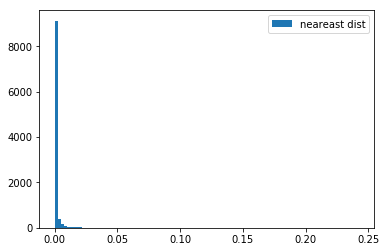

In [0]:
diffs1 = torch.tensor(diffs1).numpy()
print((diffs1==0).sum())
hist, bin_edges = np.histogram(diffs1, bins=100)
print(list(zip(hist, bin_edges)))

plt.hist([diffs1], label=['neareast dist'], bins=100)
print(bin)

plt.legend(loc='upper right')
plt.show()   

### find non-membership's nearest membership neighbour

In [0]:
diffs2 = []
with torch.no_grad():
  temp_out = torch.utils.data.DataLoader(x_out, batch_size=1, shuffle=False)
  
  for i, x in enumerate(temp_out):
    diff_norm = torch.norm(torch.sub(x_in, x), p=2, dim=1)
    diffs2.append(diff_norm.min().item())
     

tensor(3492)
[(7985, 0.0), (535, 0.06774731), (318, 0.13549462), (271, 0.20324194), (242, 0.27098924), (236, 0.33873656), (219, 0.4064839), (124, 0.47423118), (58, 0.5419785), (12, 0.60972583)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


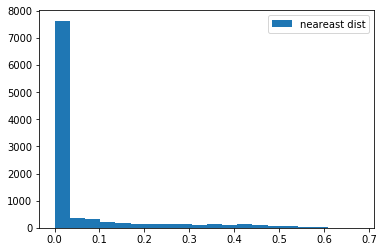

In [0]:
diffs2 = torch.tensor(diffs2)
print((diffs2<10e-6).sum())
hist, bin_edges = np.histogram(diffs2)

print(list(zip(hist, bin_edges)))

diffs2 = torch.tensor(diffs2).numpy()
# plt.xlim([0, 0.005])
plt.hist([diffs2], label=['neareast dist'], bins=20)

plt.legend(loc='upper right')
plt.show()  

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def cdf(data):

    data_size=len(data)

    # Set bins edges
    data_set=sorted(set(data))
    bins=np.append(data_set, data_set[-1]+1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)

    counts=counts.astype(float)/data_size

    # Find the cdf
    cdf = np.cumsum(counts)

    x = bin_edges[0:-1]
    y = cdf

    f = interp1d(x, y)
    f2 = interp1d(x, y, kind='cubic')

    xnew = np.linspace(0, max(x), num=1000, endpoint=True)

    # Plot the cdf
    plt.plot(x, y)
    plt.legend(['data'], loc='best')
    plt.title("cdf")
    plt.ylim((0,1))
    plt.ylabel("CDF")
    plt.grid(True)

    plt.show()

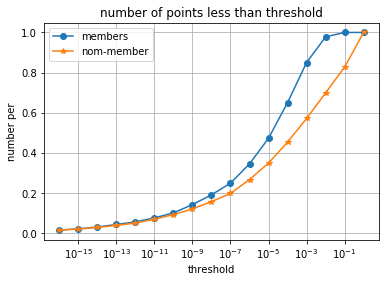

In [0]:
    # Plot the cdf
thres = 10e-17
num1 = []
num2 = []

plot_x = []

for i in range(0, 17):
  num1.append((diffs1<thres).sum()/len(diffs1))
  num2.append((diffs2<thres).sum()/len(diffs2))
  plot_x.append(thres)
  
  thres = thres * 10
plt.xscale('log')
plt.plot(plot_x, num1, '-o', plot_x, num2, '-*')
plt.legend(['members', 'nom-member'], loc='best')
plt.title("number of points less than threshold")
plt.xlabel("threshold")
plt.ylabel("number per")
plt.grid(True)

plt.show()

## prepare attacking data

In [0]:
from torch.utils.data import TensorDataset, DataLoader


train_datasets = {}
test_datasets = {}
class_num = 10
def get_ds_per_class(x_in,y_in, c_in, x_out, y_out, c_out, train_datasets, test_datasets, class_num = 10):
  train_dls = {}
  test_dls = {}
  global  test_accs# a global var for plot
  test_accs = []
  
  for i in range(0, class_num):
    print(x_in.shape, y_in.shape, c_in.shape)
    ind_in = (c_in==i).nonzero().squeeze()
    ind_out = (c_out==i).nonzero().squeeze()

    x_in_i, y_in_i = x_in[ind_in], y_in[ind_in]
    x_out_i, y_out_i = x_out[ind_out], y_out[ind_out]

    num_in = x_in_i.shape[0]
    num_out = x_out_i.shape[0]
    num_in_train = int(x_in_i.shape[0]*ration_attack_train)
    num_out_train = int(x_out_i.shape[0]*ration_attack_train)

    train_datasets[i] = TensorDataset(torch.cat([x_in_i[0:num_in_train], x_out_i[0:num_out_train]], dim=0), torch.cat([y_in_i[0:num_in_train], y_out_i[0:num_out_train]], dim=0))
    test_datasets[i] = TensorDataset(torch.cat([x_in_i[num_in_train:], x_out_i[num_out_train:]], dim=0), torch.cat([y_in_i[num_in_train:], y_out_i[num_out_train:]], dim=0))

    train_dls[i] = torch.utils.data.DataLoader(train_datasets[i], batch_size=bz, shuffle=True)
    test_dls[i] = torch.utils.data.DataLoader(test_datasets[i], batch_size=bz, shuffle=False)

    train_correct = 0
    train_total = 0

    test_correct = 0
    test_total = 0

    for x_, y_ in train_dls[i]:
      if x_.shape[0] == bz:
        ind_train = (y_==1).nonzero().squeeze(dim=1)
        train_correct +=  torch.argmax(x_[ind_train], dim=1).eq(i).sum().item()
        train_total += x_[ind_train].shape[0]

        ind_test = (y_==0).nonzero().squeeze(dim=1)
        test_correct += torch.argmax(x_[ind_test], dim=1).eq(i).sum().item()
        test_total += x_[ind_test].shape[0]
    test_accs.append(test_correct/test_total)
    print('class :{}, in_dataset of target model #correct/total={}/{} = {}'.format(i, train_correct, train_total, train_correct/train_total))
    print('class :{}, out_dataset of target model #correct/total={}/{} = {}'.format(i, test_correct, test_total, test_correct/test_total))
    
get_ds_per_class(x_in,y_in, c_in, x_out, y_out, c_out, train_datasets, test_datasets)

train_dls = {}
test_dls = {}
  
for i in range(0, class_num):
    train_dls[i] = torch.utils.data.DataLoader(train_datasets[i], batch_size=bz, shuffle=True)
    test_dls[i] = torch.utils.data.DataLoader(test_datasets[i], batch_size=bz, shuffle=False)

torch.Size([10000, 10]) torch.Size([10000]) torch.Size([10000])
class :0, in_dataset of target model #correct/total=690/690 = 1.0
class :0, out_dataset of target model #correct/total=393/686 = 0.5728862973760933
torch.Size([10000, 10]) torch.Size([10000]) torch.Size([10000])
class :1, in_dataset of target model #correct/total=711/711 = 1.0
class :1, out_dataset of target model #correct/total=440/697 = 0.6312769010043041
torch.Size([10000, 10]) torch.Size([10000]) torch.Size([10000])
class :2, in_dataset of target model #correct/total=712/712 = 1.0
class :2, out_dataset of target model #correct/total=292/696 = 0.41954022988505746
torch.Size([10000, 10]) torch.Size([10000]) torch.Size([10000])
class :3, in_dataset of target model #correct/total=686/686 = 1.0
class :3, out_dataset of target model #correct/total=259/690 = 0.3753623188405797
torch.Size([10000, 10]) torch.Size([10000]) torch.Size([10000])
class :4, in_dataset of target model #correct/total=684/684 = 1.0
class :4, out_dataset

## pca per class

In [0]:
for i in range(0, class_num):
  x_i, y_i = train_datasets[i][:]
  member = (y_i.squeeze()==1).nonzero().squeeze()
  nonmember = (y_i.squeeze()==0).nonzero().squeeze()
  
  print('class: {}\t member num:{}\t non member num:{}'.format(i, member.shape[0], nonmember.shape[0]))
  plot_pca(x_i[member], x_i[nonmember], samples=1000)

class: 0	 member num:700	 non member num:700


NameError: ignored

### attack model

In [0]:
def binary_score(target, pred):
  
  target = target.squeeze()
  pred = pred.squeeze()
  
  
  TP = ((pred == 1) & (target == 1)).sum().item()
  
  TN = ((pred == 0) & (target == 0)).sum().item()
  
  FN = ((pred == 0) & (target == 1)).sum().item()

  FP = ((pred == 1) & (target == 0)).sum().item()
  
  if TP != 0:
    p = TP / (TP + FP)
    r = TP / (TP + FN)
  else:
    p = 0
    r = 0
  
  return p,r

In [0]:
def test_scores(target, pred):
  target = target.squeeze()
  pred = pred.squeeze()
  
  
  TP = ((pred == 1) & (target == 1)).sum().item()
  
  TN = ((pred == 0) & (target == 0)).sum().item()
  
  FN = ((pred == 0) & (target == 1)).sum().item()

  FP = ((pred == 1) & (target == 0)).sum().item()
  
  
  return TP, TN, FN, FP

In [0]:
class attackModel(nn.Module):
    def __init__(self, num_in_features):
        super().__init__()
        self.fc1 = nn.Linear(num_in_features, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,1)

    def forward(self, x):
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [0]:
def train_attack_model(dataloader, model, optimizer, criterion):
  total_loss = 0
  correct = 0

  y_total = torch.tensor([])
  pred_total = torch.tensor([])
  
  model.train()
  for i, (x, y) in enumerate(dataloader):
    y = y.float().unsqueeze(dim=1)
    
    #clear cumulated gradients
    optimizer.zero_grad()
    
    # forward
    y_ = model(x)
    loss = criterion(y_, y)
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
      total_loss += loss.item()
      pred = (F.sigmoid(y_) > 0.5).float()
      y_total = torch.cat([y_total, y], dim=0)
      pred_total = torch.cat([pred_total, pred], dim=0)

      
  acc = pred_total.eq(y_total).sum().item()/pred_total.shape[0]
  print('loss: {}\tacc: {}'.format(loss.item()/(i+1), acc))
  print(binary_score(y_total, pred_total))

In [0]:

def test_attack_model(testloader, net, criterion):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    
    y_total = torch.tensor([])
    pred_total = torch.tensor([])
    times = 0
    
    with torch.no_grad():
      for i, (x, y) in enumerate(testloader):
            y = y.float().unsqueeze(dim=1)
          
            y_ = net(x)
            loss = criterion(y_, y)

            test_loss += loss.item()
            
            pred = (F.sigmoid(y_) > 0.5).float()
            y_total = torch.cat([y_total, y], dim=0)
            pred_total = torch.cat([pred_total, pred], dim=0)
            times = i
            
    acc = pred_total.eq(y_total).sum().item()/pred_total.shape[0]
#     attack_acc.append(acc)
    p, r = binary_score(y_total, pred_total)

    print('TESTING: Loss: {} | Acc: {} \t'.format(test_loss/times, acc))
    print(binary_score(y_total, pred_total))
    return test_scores(y_total, pred_total)

In [0]:
class AttackModelBundle:
  '''only one model graph exists. 
     Switching between different models is achieved by loading and saveing different params
     indexed by class_id.
  '''
  def __init__(self, num_classes, Model):
    self.num_classes = num_classes
    self.ModelClass = Model
    self.attack_model = Model(num_classes)
    self.criterion = nn.BCEWithLogitsLoss()
  
  def __get_path__(self, class_id):
    return './attackModelClass{}.pt'.format(class_id)
    
  def __reset_model__(self):
    del self.attack_model
    self.attack_model = self.ModelClass(self.num_classes)
    
  def train_class_model(self,class_id, train_dataloader, test_dataloader=None, epoch=3,is_new=True):
    print('*'*10, '\tTraing new model on class: {} \t'.format(class_id), '*'*10)
    if is_new:
      self.__reset_model__()
    optimizer = optim.Adam(self.attack_model.parameters(), lr=0.001, weight_decay=10**-7)
    
    for i in range(0, epoch):
      train_attack_model(train_dataloader, self.attack_model, optimizer, self.criterion)
      if test_dataloader is not None:
        test_attack_model(test_dataloader, self.attack_model, self.criterion)
    
    path = './attackModelClass{}.pt'.format(class_id)
    torch.save(self.attack_model.state_dict(), path)
    
    
  def test_class_model(self, class_id, dataloader):
    path = self. __get_path__(class_id)
    self.attack_model.load_state_dict(torch.load(path))
    print(dataloader)
    return test_attack_model(dataloader, self.attack_model, self.criterion)
    
  def test_all_classes(self, class_num, dataloader_dic):
    global attack_precision
    global attack_recall
    attack_precision = []
    attack_recall = []
    
    TP_total, TN_total, FN_total, FP_total = 0, 0, 0, 0

    for i in range(class_num):
      print('debug key error:', i)
      dl = dataloader_dic[i]
      TP, TN, FN, FP = self.test_class_model(i, dl)
      TP_total += TP
      TN_total += TN
      FN_total += FN
      FP_total += FP
      
      attack_precision.append(TP/(TP+FP))
      attack_recall.append(TP/(TP+FN))
    p = TP_total / (TP_total + FP_total)
    r = TP_total / (TP_total + FN_total)
    

    print('TESTING precision: {}, recall: {}'.format(p, r))
    
    print('confusion matrix:')
    print(f'TN: {TN_total}\tFP: {FP_total}\nFN: {FN_total}\t TP:{TP_total}')
    return
    

In [0]:
mab = AttackModelBundle(10, Model=attackModel)

for i in range(10):
  mab.train_class_model(i, train_dls[i], test_dls[i], epoch=10)

********** 	Traing new model on class: 0 	 **********
loss: 0.011119073087518866	acc: 0.6357142857142857
(0.5786423841059603, 0.9985714285714286)
TESTING: Loss: 0.6017082350121604 | Acc: 0.7183333333333334 	
(0.6396588486140725, 1.0)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss: 0.01055411926724694	acc: 0.7357142857142858
(0.6574427480916031, 0.9842857142857143)
TESTING: Loss: 0.5393604089816412 | Acc: 0.7266666666666667 	
(0.6471861471861472, 0.9966666666666667)
loss: 0.011333441192453558	acc: 0.7414285714285714
(0.670020120724346, 0.9514285714285714)
TESTING: Loss: 0.5387270831399493 | Acc: 0.7266666666666667 	
(0.6478260869565218, 0.9933333333333333)
loss: 0.01101046326485547	acc: 0.7428571428571429
(0.6640926640926641, 0.9828571428571429)
TESTING: Loss: 0.5415935549471114 | Acc: 0.725 	
(0.6457883369330454, 0.9966666666666667)
loss: 0.011014683680100874	acc: 0.7528571428571429
(0.6715116279069767, 0.99)
TESTING: Loss: 0.5330895516607497 | Acc: 0.7266666666666667 	
(0.6478260869565218, 0.9933333333333333)
loss: 0.009563412855971943	acc: 0.7492857142857143
(0.6685990338164252, 0.9885714285714285)
TESTING: Loss: 0.5337464809417725 | Acc: 0.7266666666666667 	
(0.6478260869565218, 0.9933333333333333)
loss: 0.010405004701831123	acc: 0.7492857142857143
(0.6

In [0]:
mab.test_all_classes(class_num=10, dataloader_dic=test_dls)

TESTING: Loss: 0.5267709460523393 | Acc: 0.735 	
(0.6556291390728477, 0.99)
TESTING: Loss: 0.5374070554971695 | Acc: 0.7265238879736409 	
(0.6496815286624203, 0.996742671009772)
TESTING: Loss: 0.3775183591577742 | Acc: 0.8484349258649094 	
(0.7694235588972431, 1.0)
TESTING: Loss: 0.36069291333357495 | Acc: 0.8592964824120602 	
(0.7855227882037533, 0.9865319865319865)
TESTING: Loss: 0.42068976660569507 | Acc: 0.8193979933110368 	
(0.7375, 0.9899328859060402)
TESTING: Loss: 0.4210546496841643 | Acc: 0.8162251655629139 	
(0.7336561743341404, 0.9967105263157895)
TESTING: Loss: 0.553742852475908 | Acc: 0.707641196013289 	
(0.6323529411764706, 0.9966887417218543)
TESTING: Loss: 0.5461807250976562 | Acc: 0.7255892255892256 	
(0.643956043956044, 0.9965986394557823)
TESTING: Loss: 0.5458954224983851 | Acc: 0.72 	
(0.6416309012875536, 0.9966666666666667)
TESTING: Loss: 0.48614975810050964 | Acc: 0.7727272727272727 	
(0.6870588235294117, 0.9931972789115646)
TESTING precision: 0.6894481643962134, 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


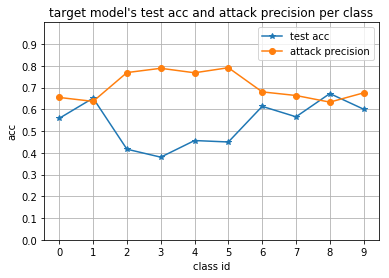

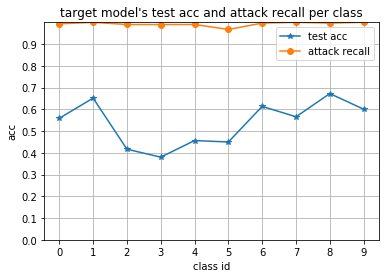

In [0]:
class_id = list(range(0, 10))
plt.xticks(range(0, 10))
plt.yticks(np.arange(0, 1, 0.1))
plt.ylim([0,1])
plt.plot(class_id, test_accs, '*-', label='test acc')
plt.plot(class_id, attack_precision, 'o-', label='attack precision')
plt.title('target model\'s test acc and attack precision per class')
plt.xlabel('class id')
plt.ylabel('acc')
plt.grid('on')
plt.legend(loc='upper right')
plt.show()

class_id = list(range(0, 10))
plt.xticks(range(0, 10))
plt.yticks(np.arange(0, 1, 0.1))
plt.ylim([0,1])
plt.plot(class_id, test_accs, '*-', label='test acc')
plt.plot(class_id, attack_recall, 'o-', label='attack recall')
plt.title('target model\'s test acc and attack recall per class')
plt.xlabel('class id')
plt.ylabel('acc')
plt.grid('on')
plt.legend(loc='upper right')
plt.show()

# difference in recall for cifar-10 

shokri: always 1

ML-Leaks: precision: 0.8, 0.8, sorted input x



In [0]:

# a simple mutiperception attack model in ML-Leaks

class attackModel1(nn.Module):
    def __init__(self, num_in_features):
        super().__init__()
        self.fc1 = nn.Linear(num_in_features, 64)
        self.fc2 = nn.Linear(64,1)

    def forward(self, x):
#         x, _ = torch.sort(x, descending=True)
#         print(x.shape)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [0]:
class attackModel2(nn.Module):
    def __init__(self, num_in_features):
        super().__init__()
        self.fc1 = nn.Linear(num_in_features, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,1)

    def forward(self, x):
        x, _ = torch.topk(x, k=3, dim=-1)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [0]:
mab1 = AttackModelBundle(10, Model=attackModel1)

for i in range(10):
  mab1.train_class_model(i, train_dls[i], test_dls[i],  epoch=20)
  
mab1.test_all_classes(class_num=10, dataloader_dic=test_dls)

********** 	Traing new model on class: 0 	 **********
loss: 0.014791210944002325	acc: 0.6113879003558719
(0.6480446927374302, 0.49361702127659574)
TESTING: Loss: 0.6857075360086229 | Acc: 0.6865671641791045 	
(0.6158536585365854, 1.0)
loss: 0.013347746296362444	acc: 0.7103202846975089
(0.6339928057553957, 1.0)
TESTING: Loss: 0.6480261915259891 | Acc: 0.693200663349917 	
(0.6209016393442623, 1.0)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss: 0.013707523996179754	acc: 0.7153024911032029
(0.6380090497737556, 1.0)
TESTING: Loss: 0.6170860694514381 | Acc: 0.6965174129353234 	
(0.6234567901234568, 1.0)
loss: 0.01232588155703111	acc: 0.7195729537366548
(0.6414922656960873, 1.0)
TESTING: Loss: 0.5959451546271642 | Acc: 0.6998341625207297 	
(0.6260330578512396, 1.0)
loss: 0.012602233073928139	acc: 0.7195729537366548
(0.6414922656960873, 1.0)
TESTING: Loss: 0.5826833579275343 | Acc: 0.7014925373134329 	
(0.6273291925465838, 1.0)
loss: 0.010975931178439747	acc: 0.7245551601423488
(0.6456043956043956, 1.0)
TESTING: Loss: 0.5742156853278478 | Acc: 0.703150912106136 	
(0.6286307053941909, 1.0)
loss: 0.009934997694058851	acc: 0.7288256227758008
(0.649171270718232, 1.0)
TESTING: Loss: 0.5693474676873949 | Acc: 0.7048092868988391 	
(0.6299376299376299, 1.0)
loss: 0.013588703491471031	acc: 0.7288256227758008
(0.649171270718232, 1.0)
TESTING: Loss: 0.5661070677969191 | Acc: 0.7048092868988391 	
(0.6299376299376299, 1.0)
loss: 0.011267

# Randomize posterior by a CNN trainined on testing dataset

defender net are the same as target model but trained on cifar-10 testing dataset.
if the attacker feed membership data of target mode, the output is defender's posteriors.
Otherwise, output is target model's posteriors.

In [0]:
# defender_x, defender_y, defender_c

print('non-membership number:', defender_y.eq(0).sum().item())

defenderDs = {}
defenderDls = {}
num_classes = 10
for i in range(0, num_classes):
  class_i = defender_c.eq(i).nonzero().squeeze(dim=1)
  defenderDs[i] = TensorDataset(defender_x[class_i], defender_y[class_i])
  defenderDls[i] =  torch.utils.data.DataLoader(defenderDs[i], batch_size=bz, shuffle=False)


mab.test_all_classes(class_num=10, dataloader_dic=defenderDls)   

non-membership number: 0
TESTING: Loss: 6.679849670779321 | Acc: 0.457 	
(1.0, 0.457)
TESTING: Loss: 8.064151640861265 | Acc: 0.530791788856305 	
(1.0, 0.530791788856305)
TESTING: Loss: 7.0921243544547785 | Acc: 0.34833659491193736 	
(1.0, 0.34833659491193736)
TESTING: Loss: 10.49216882387797 | Acc: 0.2595959595959596 	
(1.0, 0.2595959595959596)
TESTING: Loss: 7.62769668896993 | Acc: 0.3763874873864783 	
(1.0, 0.3763874873864783)
TESTING: Loss: 9.849604206700478 | Acc: 0.32245301681503463 	
(1.0, 0.32245301681503463)
TESTING: Loss: 8.739103409551806 | Acc: 0.47960199004975124 	
(1.0, 0.47960199004975124)
TESTING: Loss: 7.279148785273234 | Acc: 0.47653061224489796 	
(1.0, 0.47653061224489796)
TESTING: Loss: 9.93318723863171 | Acc: 0.5400801603206413 	
(1.0, 0.5400801603206413)
TESTING: Loss: 9.248117176691691 | Acc: 0.4785714285714286 	
(1.0, 0.4785714285714286)
TESTING precision: 1.0, recall: 0.4269
confusion matrix:
TN: 0	FP: 0
FN: 5731	 TP:4269


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
